<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch04/04_karaage_ai_book_gan_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANを使って手の形の画像を生成する方法

## 教師データのダウンロード

ジャンケンの手の形の教師データをGitHubからダウンロード（Clone）します。

2,3行目はダウンロードしたデータから、使用するデータ以外の不要なファイルを削除しています。

In [ ]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf /content/datasets/.git
!rm /content/datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 36.21 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## データの前処理（データ水増し）

画像生成の成功率を上げるために、データの前処理（データの水増し）を行います。

データの前処理のあり、無しで効果の違いを確認してみてください。

データ水増し用のディレクトリを定義

In [ ]:
train_aug_dir = 'datasets'

必要なライブラリをインポート

In [ ]:
import cv2
import numpy as np
import sys
import os
import glob

In [ ]:
# ヒストグラム均一化
def equalizeHistRGB(src):
    RGB = cv2.split(src)
    Blue   = RGB[0]
    Green = RGB[1]
    Red    = RGB[2]
    for i in range(3):
        cv2.equalizeHist(RGB[i])

    img_hist = cv2.merge([RGB[0],RGB[1], RGB[2]])
    return img_hist

# ガウシアンノイズ
def addGaussianNoise(src):
    row,col,ch= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = src + gauss

    return noisy

# salt&pepperノイズ
def addSaltPepperNoise(src):
    row,col,ch = src.shape
    s_vs_p = 0.5
    amount = 0.004
    out = src.copy()
    # Salt mode
    num_salt = np.ceil(amount * src.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt))
                 for i in src.shape]
    out[coords[:-1]] = (255,255,255)

    # Pepper mode
    num_pepper = np.ceil(amount* src.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper))
             for i in src.shape]
    out[coords[:-1]] = (0,0,0)

    return out

In [ ]:
labels = os.listdir(train_aug_dir)

print(labels)
image_file_names = []

for label in labels:
  image_files = glob.glob(train_aug_dir + '/' + label +'/*')
  for image_file in image_files:
    image_file_names.append(image_file)

print(image_file_names)

['gu', 'choki', 'pa']
['datasets/gu/IMG_0755.JPG', 'datasets/gu/IMG_0764.JPG', 'datasets/gu/IMG_0886.JPG', 'datasets/gu/IMG_0729.JPG', 'datasets/gu/IMG_0732.JPG', 'datasets/gu/IMG_0740.JPG', 'datasets/gu/IMG_0735.JPG', 'datasets/gu/IMG_0742.JPG', 'datasets/gu/IMG_0892.JPG', 'datasets/gu/IMG_0751.JPG', 'datasets/gu/IMG_0752.JPG', 'datasets/gu/IMG_0745.JPG', 'datasets/gu/IMG_0887.JPG', 'datasets/gu/IMG_0894.JPG', 'datasets/gu/IMG_0728.JPG', 'datasets/gu/IMG_0765.JPG', 'datasets/gu/IMG_0741.JPG', 'datasets/gu/IMG_0888.JPG', 'datasets/gu/IMG_0739.JPG', 'datasets/gu/IMG_0759.JPG', 'datasets/gu/IMG_0766.JPG', 'datasets/gu/IMG_0748.JPG', 'datasets/gu/IMG_0754.JPG', 'datasets/gu/IMG_0758.JPG', 'datasets/gu/IMG_0749.JPG', 'datasets/gu/IMG_0767.JPG', 'datasets/gu/IMG_0738.JPG', 'datasets/gu/IMG_0761.JPG', 'datasets/gu/IMG_0762.JPG', 'datasets/gu/IMG_0730.JPG', 'datasets/gu/IMG_0734.JPG', 'datasets/gu/IMG_0746.JPG', 'datasets/gu/IMG_0889.JPG', 'datasets/gu/IMG_0733.JPG', 'datasets/gu/IMG_0890.JPG

In [ ]:
# ルックアップテーブルの生成
min_table = 50
max_table = 205
diff_table = max_table - min_table
gamma1 = 0.75
gamma2 = 1.5

LUT_HC = np.arange(256, dtype = 'uint8')
LUT_LC = np.arange(256, dtype = 'uint8')
LUT_G1 = np.arange(256, dtype = 'uint8')
LUT_G2 = np.arange(256, dtype = 'uint8')

LUTs = []

# 平滑化用
average_square = (10,10)

# ハイコントラストLUT作成
for i in range(0, min_table):
  LUT_HC[i] = 0

for i in range(min_table, max_table):
  LUT_HC[i] = 255 * (i - min_table) / diff_table

for i in range(max_table, 255):
  LUT_HC[i] = 255

# その他LUT作成
for i in range(256):
  LUT_LC[i] = min_table + i * (diff_table) / 255
  LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
  LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)

LUTs.append(LUT_HC)
LUTs.append(LUT_LC)
LUTs.append(LUT_G1)
LUTs.append(LUT_G2)


for image_file in image_file_names:
#  print(image_file)
  # 画像の読み込み
  img_src = cv2.imread(image_file, 1)
  trans_img = []
  trans_img.append(img_src)

  # LUT変換
  for i, LUT in enumerate(LUTs):
    trans_img.append(cv2.LUT(img_src, LUT))

	# 平滑化
  trans_img.append(cv2.blur(img_src, average_square))

	# ヒストグラム均一化
  trans_img.append(equalizeHistRGB(img_src))

	# ノイズ付加
  trans_img.append(addGaussianNoise(img_src))
  trans_img.append(addSaltPepperNoise(img_src))

	# 反転
  flip_img = []
  for img in trans_img:
     flip_img.append(cv2.flip(img, 1))
  trans_img.extend(flip_img)

  dir_name = os.path.splitext(os.path.dirname(image_file))[0]
  base_name = os.path.splitext(os.path.basename(image_file))[0]
  img_src.astype(np.float64)
  
  for i, img in enumerate(trans_img):
    if i > 0:
      cv2.imwrite(dir_name + '/trans_' + base_name + '_' + str(i-1) + '.jpg' ,img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


ディレクトリの中身を確認します。

In [ ]:
!ls datasets/choki

choki_01.jpg	       trans_IMG_0788_16.jpg  trans_IMG_0811_5.jpg
IMG_0770.JPG	       trans_IMG_0788_1.jpg   trans_IMG_0811_6.jpg
IMG_0771.JPG	       trans_IMG_0788_2.jpg   trans_IMG_0811_7.jpg
IMG_0772.JPG	       trans_IMG_0788_3.jpg   trans_IMG_0811_8.jpg
IMG_0773.JPG	       trans_IMG_0788_4.jpg   trans_IMG_0811_9.jpg
IMG_0774.JPG	       trans_IMG_0788_5.jpg   trans_IMG_0812_0.jpg
IMG_0775.JPG	       trans_IMG_0788_6.jpg   trans_IMG_0812_10.jpg
IMG_0776.JPG	       trans_IMG_0788_7.jpg   trans_IMG_0812_11.jpg
IMG_0777.JPG	       trans_IMG_0788_8.jpg   trans_IMG_0812_12.jpg
IMG_0778.JPG	       trans_IMG_0788_9.jpg   trans_IMG_0812_13.jpg
IMG_0779.JPG	       trans_IMG_0789_0.jpg   trans_IMG_0812_14.jpg
IMG_0780.JPG	       trans_IMG_0789_10.jpg  trans_IMG_0812_15.jpg
IMG_0781.JPG	       trans_IMG_0789_11.jpg  trans_IMG_0812_16.jpg
IMG_0782.JPG	       trans_IMG_0789_12.jpg  trans_IMG_0812_1.jpg
IMG_0783.JPG	       trans_IMG_0789_13.jpg  trans_IMG_0812_2.jpg
IMG_0784.JPG	       trans_IMG_078

水増しされたファイル(`trans_xxx.jpg`) というファイルが大量にあればOKです。

水増しされたデータを確認してみましょう。

代表例として、冒頭確認したチョキの画像の水増しされた画像を結合して、1枚の写真にして表示します。

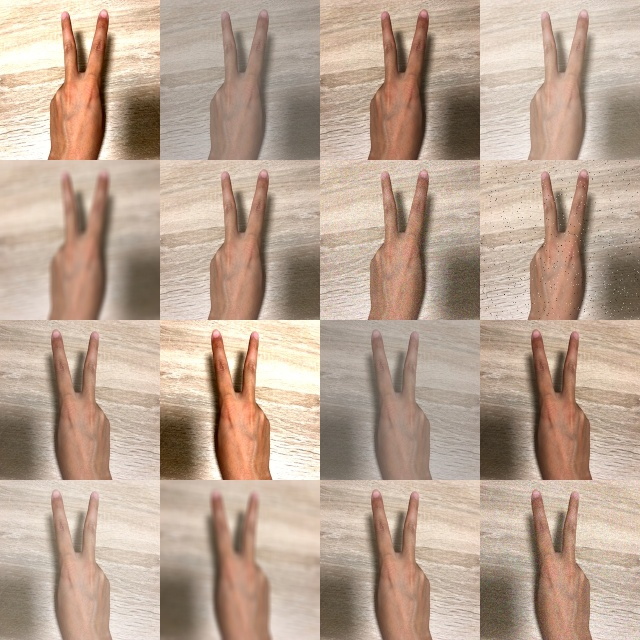

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display_jpeg

tmp_file_name = './datasets/choki/trans_choki_01'

tmp_image = []
for i in range(16):
  tmp_image.append(cv2.imread(tmp_file_name + '_' + str(i) + '.jpg'))

tmp_hconcat_image = []
tmp_hconcat_image.append(cv2.hconcat(tmp_image[0:4]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[4:8]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[8:12]))
tmp_hconcat_image.append(cv2.hconcat(tmp_image[12:16]))

concat_image = cv2.vconcat(tmp_hconcat_image[0:4])
concat_image = cv2.resize(concat_image, dsize=(640, 640))
cv2.imwrite('concat.jpg', concat_image)

display_jpeg(IPImage('concat.jpg'))

## GANのモデルの学習

### 学習の事前準備

バージョンの変更

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


必要なライブラリをインポートします

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten
from keras.optimizers import Adam
import numpy as np
from PIL import Image
import glob
import random
import time
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

Using TensorFlow backend.


最初にGANの学習やテストに必要な関数を定義しておきます

教師データのディレクトリから画像を読み込んでひとまとまり（バッチ）にする関数を定義します。

画像認識の場合は、データの変換をしてくれる便利な関数がありましたが、GANの場合はそのような便利な関数がないので、自分で頑張って変換をしていると理解してください。

やっていることは、ファイルを読み込んでTensorFlow(Keras)で学習できるように画像のサイズや、値の範囲を調整しているだけです。

In [ ]:
def image_batch(batch_size):
  files = glob.glob('./datasets/*/*')
  files = random.sample(files, batch_size)
  res = []
  for path in files:
    img = Image.open(path)
    img = img.resize((64, 64))
    arr = np.array(img)
    arr = (arr - 127.5) / 127.5
    arr.resize((64, 64, 3))
    res.append(arr)
  return np.array(res)

実際どのような動きをするのか試してみましょう。以下を実行すると25個分のデータがバッチとして読み込まれます。

形式は numpy.ndarray となります。

In [ ]:
test_image = image_batch(25)
print(type(test_image))

<class 'numpy.ndarray'>


試しに表示してみましょう。手の画像が表示されました。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


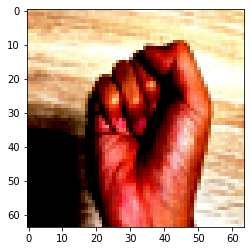

In [ ]:
plt.imshow(test_image[0])

画像の色が変なのは、TensorFlow（Keras）で学習させるために、値の範囲を調整しているためです。

例えば以下のように少し値を調整すると、元の画像が表示できます。

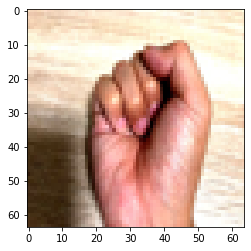

In [ ]:
plt.imshow((test_image[0] + 1) / 2)
#plt.imshow((test_image[0] * 127.5 +127.5) / 255)

次に、生成した画像をひとまとめにする関数を定義します。これは、複数の画像をまとめることでテスト結果をみやすくするものです。

ディープラーニングの学習とは直接関係ありませんが、このように結果の画像を見やすく加工することは、重要なテクニックなので使えるようにしておくと便利です。

In [ ]:
def combine_images(generated_images, cols=5, rows=5):
  shape = generated_images.shape
  h = shape[1]
  w = shape[2]
  image = np.zeros((rows * h,  cols * w, 3))
  for index, img in enumerate(generated_images):
    if index >= cols * rows:
      break
    i = index // cols
    j = index % cols
    image[i * h:(i + 1) * h, j * w:(j + 1) * w, :] = img[:, :, :]
  image = image * 127.5 + 127.5
  image = Image.fromarray(image.astype(np.uint8))
  return image

では、さきほどバッチとして読み込んだ画像を結合してみましょう。

In [ ]:
test_combined_image = combine_images(test_image)

表示してみます。

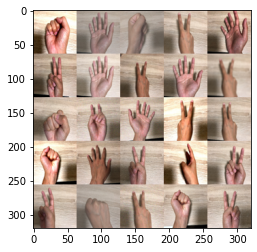

In [ ]:
plt.imshow(test_combined_image)

結合された画像が表示されましたね。

これで事前準備が完了したので、いよいよGANの学習をしていきます。

### GANの学習

ハイパーパラメータのセッティングをします。

In [ ]:
batch_size = 32
epochs = 1001
#epochs = 101

その他、モデルの保存場所、生成した画像の保存場所、何世代毎に学習結果を確認するかを設定をします。

In [ ]:
model_dir = './model'
gen_images_dir = './gen_images'
each_step = 50

贋作者ネットワークの定義をします。

In [ ]:
def generator_model():
  model = Sequential()

  model.add(Dense(1024, input_shape=(100,)))
  model.add(Activation('tanh'))

  model.add(Dense(128 * 16 * 16))
  model.add(BatchNormalization())
  model.add(Activation('tanh'))

  model.add(Reshape((16, 16, 128)))
  model.add(UpSampling2D(size=(2, 2)))
  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(Activation('tanh'))

  model.add(UpSampling2D(size=(2, 2)))
  model.add(Conv2D(3, (5, 5), padding='same'))
  model.add(Activation('tanh'))
  return model

鑑定士ネットワークの定義をします。

In [ ]:
def discriminator_model():
  model = Sequential()

  model.add(Conv2D(64, (5, 5), input_shape=(64, 64, 3), padding='same'))
  model.add(Activation('tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (5, 5)))
  model.add(Activation('tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())

  model.add(Dense(1024))
  model.add(Activation('tanh'))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  return model

GANの性能を評価するための贋作者と鑑定士両方を含んだネットワークを定義します。

In [ ]:
def generator_containing_discriminator(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

モデルを作成して確認します。

In [ ]:
def set_trainable(model, trainable):
  model.trainable = trainable
  for layer in model.layers:
    layer.trainable = trainable

discriminator = discriminator_model()
generator = generator_model()
discriminator_on_generator = generator_containing_discriminator(
    generator, discriminator)

set_trainable(discriminator, True)
discriminator.compile(
    loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

set_trainable(discriminator, False)
discriminator_on_generator.compile(
    loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

print(generator.summary())
print(discriminator.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              103424    
_________________________________________________________________
activation_21 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32768)             33587200  
_________________________________________________________________
batch_normalization_3 (Batch (None, 32768)             131072    
_________________________________________________________________
activation_22 (Activation)   (None, 32768)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 128)       0         
__________________________

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ここでのポイントは、set_trainable という関数です。これは、学習のときにモデルの重みを更新するかどうか（要は、そのモデルの学習を進めるかどうか）を切り替える関数です。

GANは、贋作者のモデルと、鑑定士のモデルが交互に学習することで性能を高めるという話を最初にしました。なので、贋作者のモデルが学習しているときは、鑑定士の学習は止まっていて欲しいですし、鑑定士のモデルが学習するときは、贋作者のモデルの学習は止まっていて欲しいわけです。

問題は、贋作者のモデルを学習するために、自分が生成した画像が正しい画像かどうかを鑑定士に評価してもらう必要があるため、贋作者と鑑定士をくっつけたモデルにしている点です。ここでは、贋作者のモデルのみを学習させたいので、鑑定士のモデルの学習は止まっていて欲しいです。

そのため、set_trainableという関数を使って、贋作者のモデルの学習時は、鑑定士のモデルを学習しないように設定しています。

モデルの学習

学習過程を保存するリストの準備と、生成した画像を保存するディレクトリを作成します。

In [ ]:
if not os.path.isdir(gen_images_dir):
  os.mkdir(gen_images_dir)

学習のプログラムです。

  0%|          | 0/1001 [00:00<?, ?it/s]

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


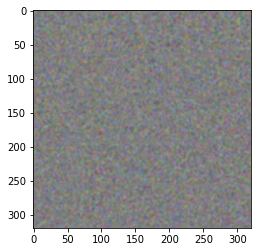

  0%|          | 1/1001 [00:19<5:21:08, 19.27s/it]/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  5%|▍         | 50/1001 [00:27<02:33,  6.21it/s]

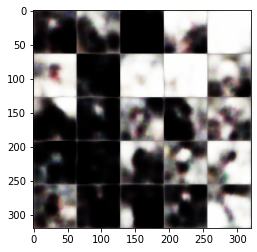

 10%|▉         | 100/1001 [00:35<02:26,  6.15it/s]

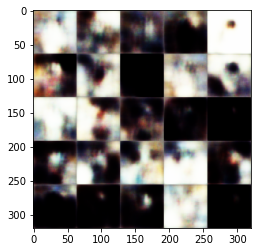

 15%|█▍        | 150/1001 [00:43<02:18,  6.14it/s]

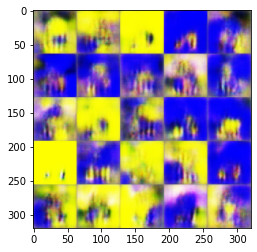

 20%|█▉        | 200/1001 [00:52<02:10,  6.14it/s]

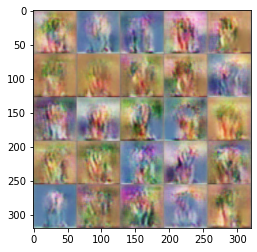

 25%|██▍       | 250/1001 [01:00<01:59,  6.29it/s]

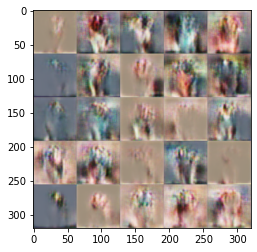

 30%|██▉       | 300/1001 [01:08<01:53,  6.15it/s]

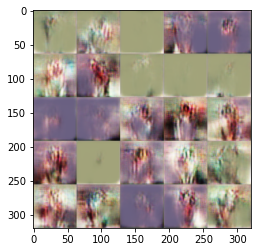

 35%|███▍      | 350/1001 [01:16<01:43,  6.27it/s]

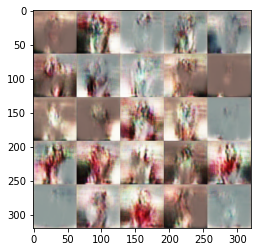

 40%|███▉      | 400/1001 [01:24<01:35,  6.28it/s]

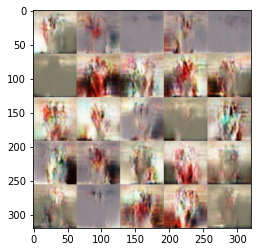

 45%|████▍     | 450/1001 [01:33<01:27,  6.27it/s]

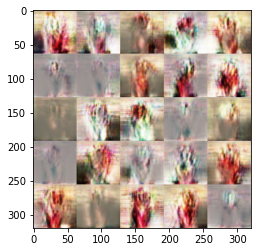

 50%|████▉     | 500/1001 [01:41<01:20,  6.21it/s]

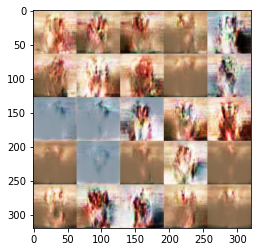

 55%|█████▍    | 550/1001 [01:50<01:13,  6.16it/s]

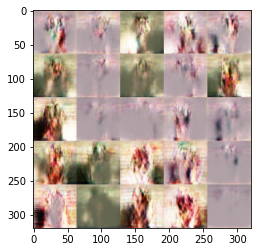

 60%|█████▉    | 600/1001 [01:58<01:04,  6.23it/s]

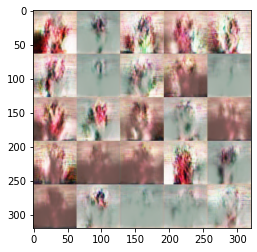

 65%|██████▍   | 650/1001 [02:06<00:56,  6.26it/s]

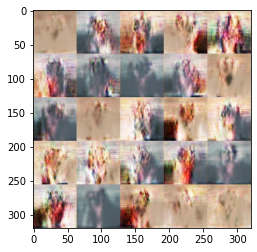

 70%|██████▉   | 700/1001 [02:14<00:48,  6.22it/s]

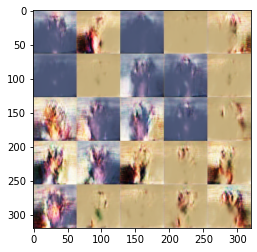

 75%|███████▍  | 750/1001 [02:23<00:40,  6.23it/s]

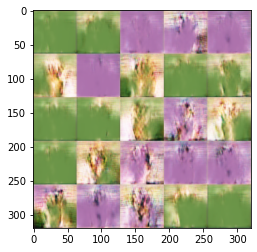

 80%|███████▉  | 800/1001 [02:31<00:32,  6.27it/s]

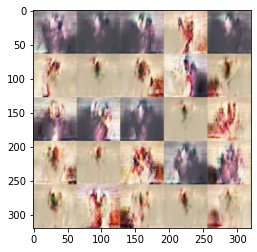

 85%|████████▍ | 850/1001 [02:39<00:24,  6.20it/s]

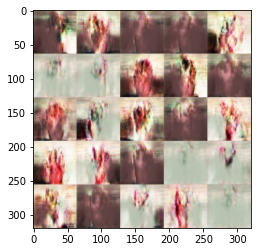

 90%|████████▉ | 900/1001 [02:47<00:16,  6.31it/s]

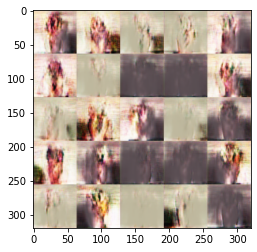

 95%|█████████▍| 950/1001 [02:56<00:08,  6.22it/s]

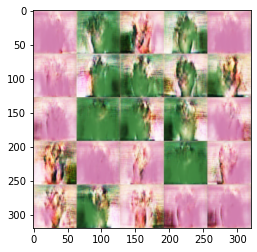

100%|█████████▉| 1000/1001 [03:04<00:00,  6.22it/s]

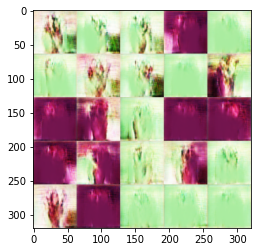

100%|██████████| 1001/1001 [03:04<00:00,  5.42it/s]


In [ ]:
# graph data
csvlist = []
csvlist.append([])
csvlist[0].append('step')
csvlist[0].append('g_loss')
csvlist[0].append('d_loss')

for i in tqdm(range(epochs)):
  batch_images = image_batch(batch_size)
  noise = np.random.uniform(
      size=[batch_size, 100], low=-1.0, high=1.0)
  generated_images = generator.predict(noise)
  X = np.concatenate((batch_images, generated_images))
  y = [1] * batch_size + [0] * batch_size
  d_loss = discriminator.train_on_batch(X, y)
  noise = np.random.uniform(
      size=[batch_size, 100], low=-1.0, high=1.0)
  g_loss = discriminator_on_generator.train_on_batch(
      noise, [1] * batch_size)

  # add graph data
  csvlist.append([])
  csvlist[i+1].append(i)
  csvlist[i+1].append(g_loss)
  csvlist[i+1].append(d_loss)

  if i % each_step == 0:
    # show result image
    image = combine_images(generated_images)
    plt.ion()
    plt.imshow(image)
    plt.pause(0.001)

    # save image
    image.save(gen_images_dir + '/gen%05d.png' % i)

# save graph data(csv)
with open('./train_graph.csv', 'w') as f:
  dataWriter = csv.writer(f)
  dataWriter.writerows(csvlist)

学習結果を可視化します。

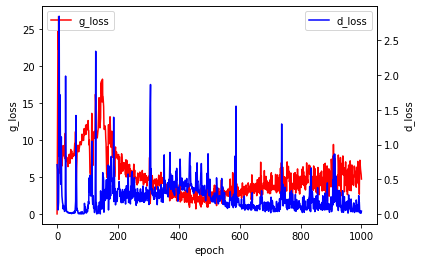

In [ ]:
data = pd.read_csv("train_graph.csv", index_col='step')

fig, ax1 = plt.subplots()
df_acc = data.iloc[:, [0]]
df_val_acc = data.iloc[:, [1]]

ax1.plot(df_acc, 'r', label='g_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('g_loss')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_val_acc, 'b', label='d_loss')
ax2.set_ylabel('d_loss')
ax2.legend(loc='upper right')

plt.show()

学習データの保存

In [ ]:
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

save_model_path = os.path.join(model_dir, 'gan_model.h5')

generator.save(save_model_path)

学習データの確認

In [ ]:
!ls './gen_images'

gen00000.png  gen00250.png  gen00500.png  gen00750.png	gen01000.png
gen00050.png  gen00300.png  gen00550.png  gen00800.png
gen00100.png  gen00350.png  gen00600.png  gen00850.png
gen00150.png  gen00400.png  gen00650.png  gen00900.png
gen00200.png  gen00450.png  gen00700.png  gen00950.png


生成された画像を確認

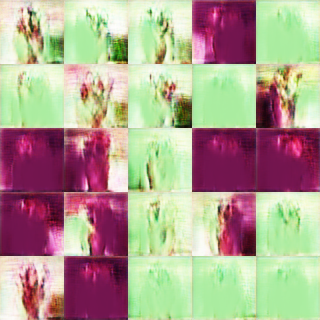

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display_png

display_png(IPImage('./gen_images/gen01000.png'))

画像ファイルを圧縮してダウンロード

In [ ]:
!tar cvzf images.tar.gz ./gen_images

./gen_images/
./gen_images/gen00900.png
./gen_images/gen00000.png
./gen_images/gen00300.png
./gen_images/gen00050.png
./gen_images/gen00750.png
./gen_images/gen00150.png
./gen_images/gen00400.png
./gen_images/gen00250.png
./gen_images/gen00500.png
./gen_images/gen00450.png
./gen_images/gen00650.png
./gen_images/gen00600.png
./gen_images/gen00800.png
./gen_images/gen00550.png
./gen_images/gen01000.png
./gen_images/gen00700.png
./gen_images/gen00200.png
./gen_images/gen00950.png
./gen_images/gen00100.png
./gen_images/gen00850.png
./gen_images/gen00350.png


In [ ]:
from google.colab import files
files.download('images.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

学習のログのダウンロード

In [ ]:
#from google.colab import files
#files.download('train_graph.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

モデルファイルの保存をします（Google Drive連携）

モデルファイルの容量が大きいので、直接ダウンロードは失敗することが多いため、Google Drive連携をするようにしてください。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp ./model/gan_model.h5 '/content/drive/My Drive'

## 参考リンク

### GANのネットワーク

- https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/scripts_keras/dcgan_keras.py
- https://github.com/jacobgil/keras-dcgan
- https://qiita.com/t-ae/items/236457c29ba85a7579d5
- https://arxiv.org/abs/1511.06434

### 乱数(Seed)固定
- https://scrapbox.io/nwtgck/Tensorflow+Keras%E3%81%A7%E5%86%8D%E7%8F%BE%E6%80%A7%E3%81%AE%E3%81%82%E3%82%8B%E4%B9%B1%E6%95%B0%E3%82%92%E7%94%9F%E6%88%90%E3%81%99%E3%82%8B_-_%E3%82%B7%E3%83%BC%E3%83%89%E5%9B%BA%E5%AE%9A
- https://qiita.com/okotaku/items/8d682a11d8f2370684c9